In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir='/kaggle/input/egyptian-hieroglyphs/train/'
val_dir='/kaggle/input/egyptian-hieroglyphs/valid/'
test_dir='/kaggle/input/egyptian-hieroglyphs/test/'

train_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv')
val_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv')
test_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv')

In [3]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,nile-fish-7-_jpg.rf.31e4278980878c47a1e6a2f8dd...,640,640,Nile_Fish,375,319,512,454
1,Her-8-_jpg.rf.32bcf63f4ae4d6aea53cea5b9c0059b4...,640,640,Her,211,247,368,339
2,composite_bow-34-_jpg.rf.33153e63f7158777c50d4...,640,640,Composite_Bow,158,183,336,282
3,snake-6-_jpg.rf.32ac52ece4bcc06b1ead936693df17...,640,640,Snake,181,351,318,506
4,king-26-_jpg.rf.329a5a8e366f4fe2e3a3dca88524cc...,640,640,King,218,290,339,524


In [4]:
x_train=[]
y_train=[]


files=train_df['filename']

x_min=train_df['xmin']
x_max=train_df['xmax']
y_min=train_df['ymin']
y_max=train_df['ymax']

i=0

for filename in files:
    image=cv2.imread(os.path.join(train_dir,filename))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_train.append(rgb_image)
    i+=1

    
y_train=train_df['class']

In [5]:
lst=train_df['class'].unique()
len(lst)

95

In [6]:
print(len(x_train),len(y_train))

2723 2723


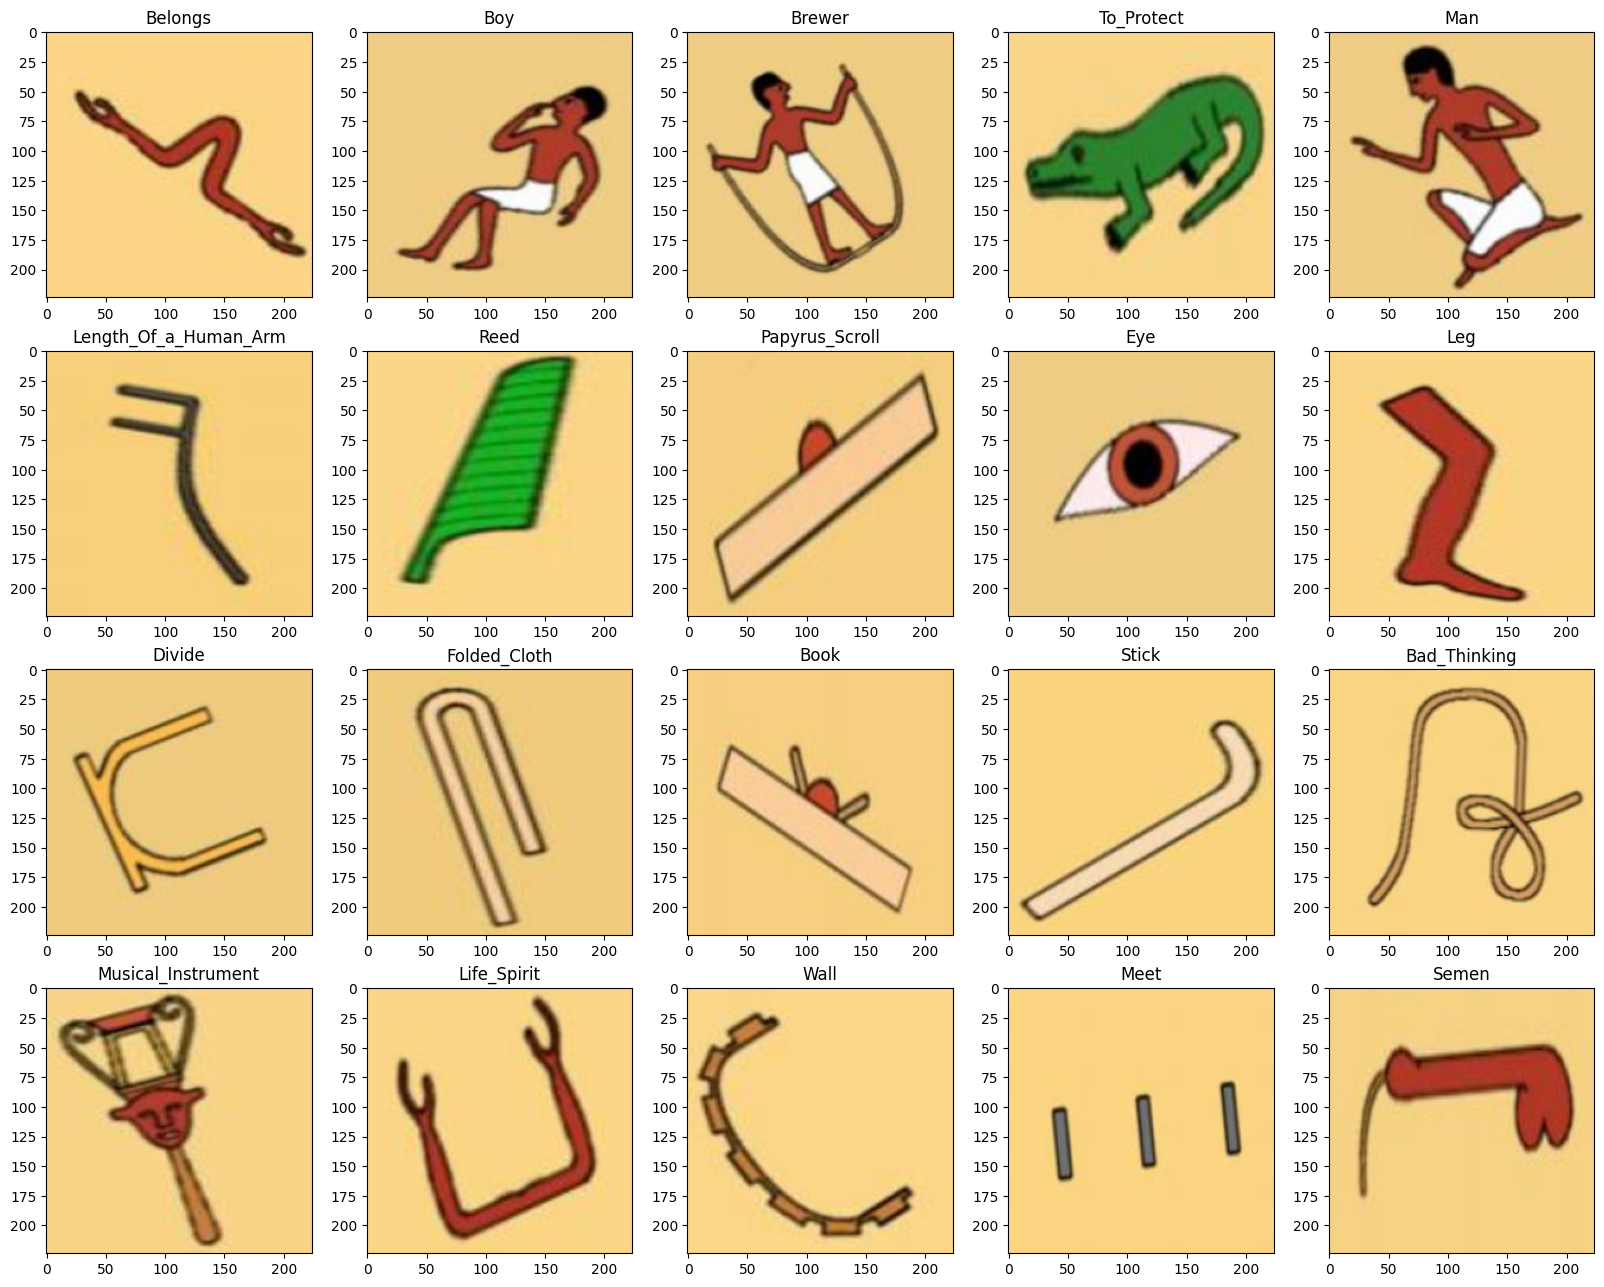

In [7]:
rand_idx=list(np.random.randint(0,len(x_train),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    cnt+=1

In [8]:
for i in range(len(x_train)):
    x_train[i]=x_train[i]/255.0

In [9]:
x_val=[]
y_val=val_df['class']
files=val_df['filename']

x_min=val_df['xmin']
x_max=val_df['xmax']
y_min=val_df['ymin']
y_max=val_df['ymax']

i=0

for file in files:
    image=cv2.imread(os.path.join(val_dir,file))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_val.append(rgb_image)
    i+=1
    

In [10]:
for i in range(len(x_val)):
    x_val[i]=x_val[i]/255.0

In [11]:
print(len(x_val),len(y_val))

778 778


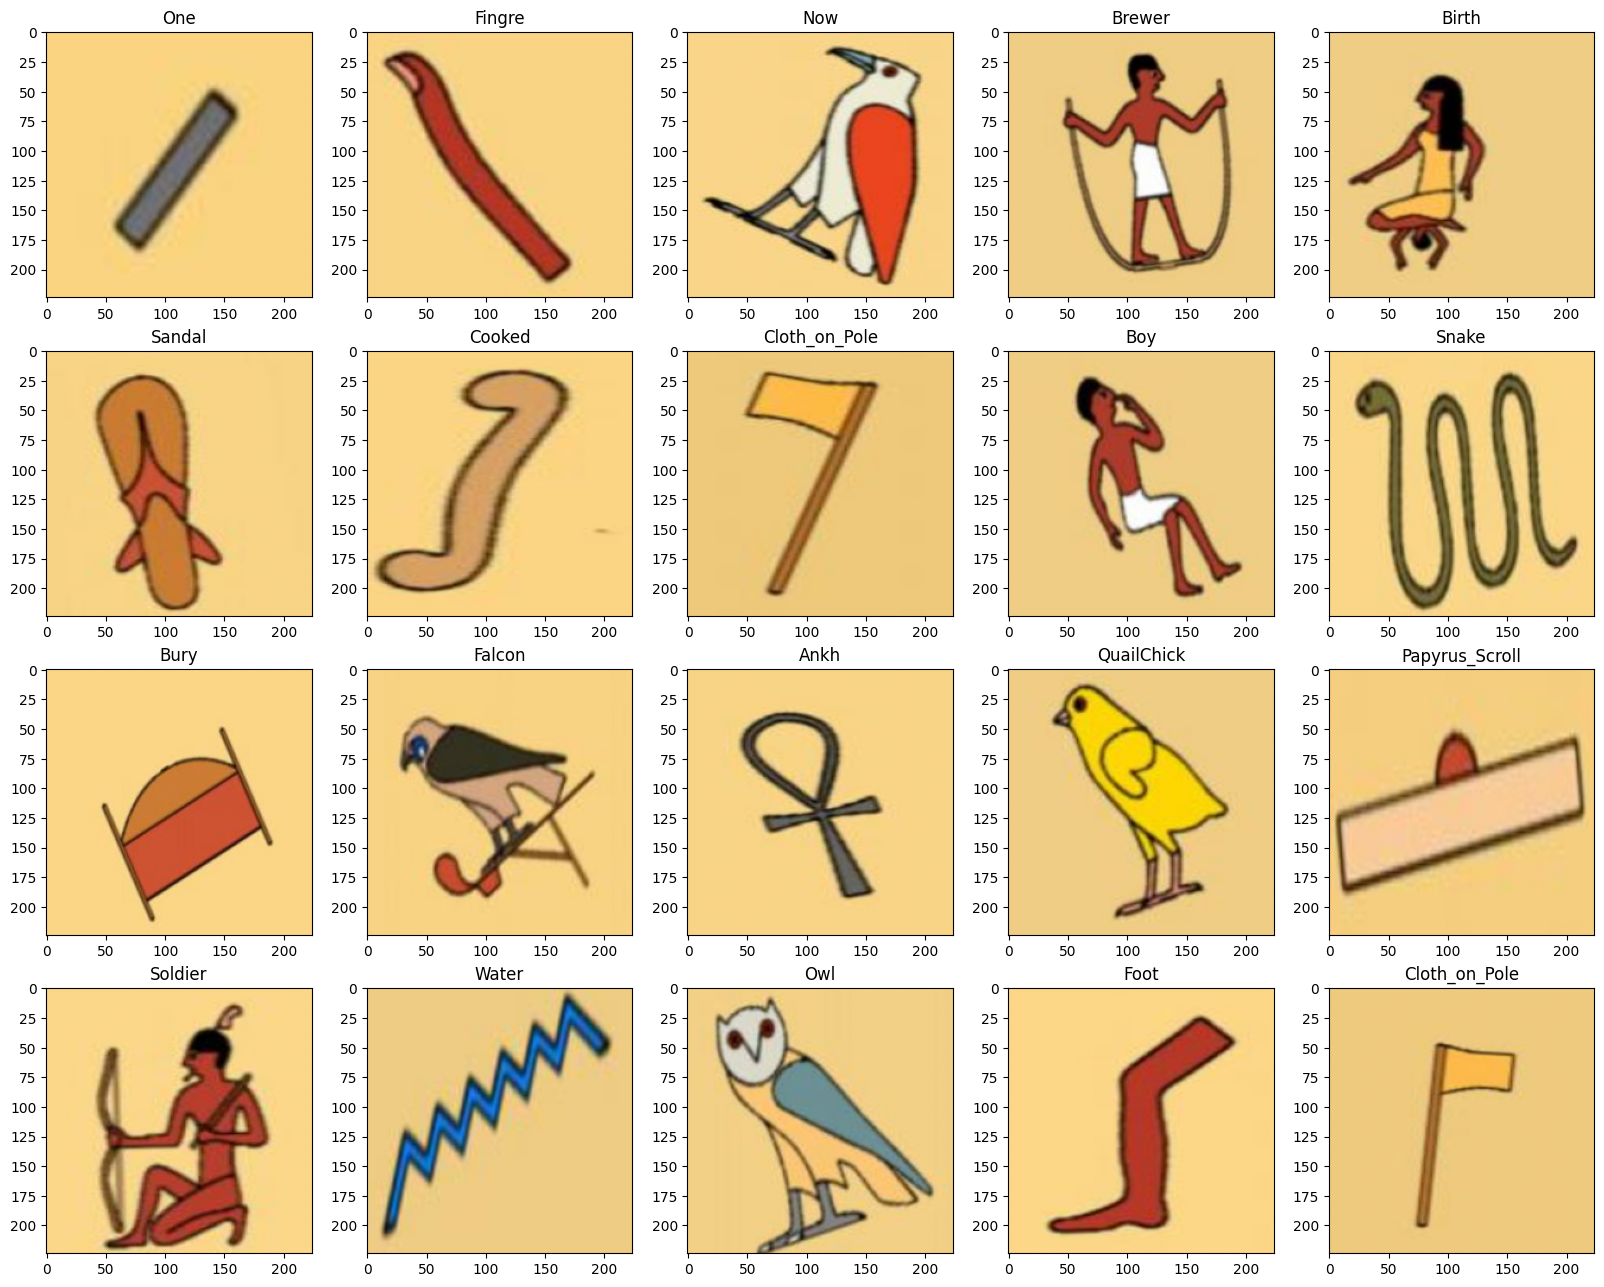

In [12]:
rand_idx=list(np.random.randint(0,len(x_val),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_val[i])
    plt.title(y_val[i])
    cnt+=1

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [14]:
x_train=np.array(x_train)
x_train= x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
y_train=np.array(y_train)
x_val=np.array(x_val)
x_val= x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)
y_val=np.array(y_val)

In [15]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(2723, 224, 224, 3) (2723,) (778, 224, 224, 3) (778,)


In [16]:
from sklearn.utils import shuffle
x_train,y_train = shuffle(x_train,y_train)

In [17]:
input_shape=(224,224,3)
inputs=tf.keras.Input(shape=input_shape)
base_model=tf.keras.applications.ResNet152(include_top=False,weights='imagenet',input_tensor=inputs)
base_model.trainable=True

var=tf.keras.layers.Flatten()(base_model.output)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(256,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

outputs=tf.keras.layers.Dense(95,activation='softmax')(var)

model=tf.keras.models.Model(inputs=inputs,outputs=outputs)

opt=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])



234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 71,326,175 (272.09 MB)

 Trainable params: 71,173,215 (271.50 MB)

 Non-trainable params: 152,960 (597.50 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
learning_rate=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6,patience=10)
ckeck_points=ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True,save_weights_only=False)

In [20]:
history=model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_val,y_val),callbacks=[early_stopping,learning_rate,ckeck_points],shuffle=True)

Epoch 1/20


I0000 00:00:1735055361.198033      98 service.cc:145] XLA service 0x78deb80027b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735055361.198091      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735055457.059636      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1735055457.173793      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.0140 - loss: 5.2939

I0000 00:00:1735055575.125237      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_65', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_62', 456 bytes spill stores, 456 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.0141 - loss: 5.2906 - val_accuracy: 0.0154 - val_loss: 46842568.0000 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 462ms/step - accuracy: 0.0110 - loss: 5.1140 - val_accuracy: 0.0064 - val_loss: 4.6840 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 401ms/step - accuracy: 0.0358 - loss: 4.5820 - val_accuracy: 0.0064 - val_loss: 5.0563 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 398ms/step - accuracy: 0.0346 - loss: 4.3394 - val_accuracy: 0.0077 - val_loss: 5.6287 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 398ms/step - accuracy: 0.0602 - loss: 3.8698 - val_accuracy: 0.0090 - val_loss: 5.8304 - learning_rate: 0.0010
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 397ms/step - accuracy: 0.0616 - loss: 3.7807 - val_accuracy: 0.0077 - val_loss: 5.8247 - learning_rate: 0.0010
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 399ms/step - accuracy: 0.0659 - loss: 3.6065 -

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

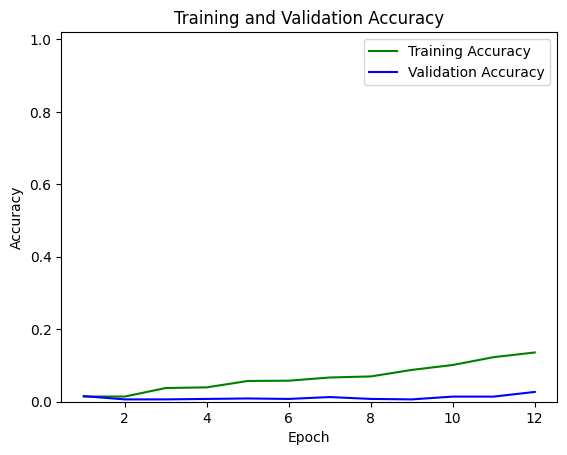

In [22]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

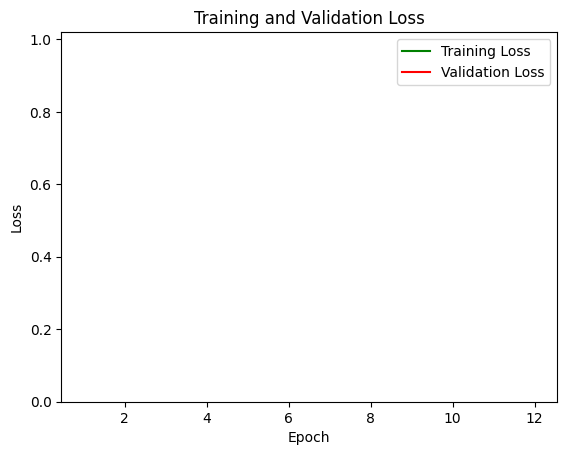

In [23]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [24]:
# Evaluate the model
model_evaluate = model.evaluate(x_train,y_train)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.0142 - loss: 4.6898
Loss     :  4.682218074798584
Accuracy :  0.012118986807763577


In [25]:
# Evaluate the model
model_evaluate = model.evaluate(x_val,y_val)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.0059 - loss: 4.6743
Loss     :  4.684048652648926
Accuracy :  0.006426735315471888
